In [2]:
#尝试研究B达成的规律性


import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import statsmodels.api as sm


In [111]:
# 读取 CSV 文件并创建 DataFrame
accept_pv_df = pd.read_csv('accept_pv.csv', header=0)


# 打印 DataFrame 的第一行
first_row = accept_pv_df.head(n=1)
# print(first_row)

accept_pv_df.head(20)

,ds,uid,pv
0,2023/7/6,100000044,1
1,2023/6/18,100000044,1
2,2022/9/21,100000044,1
3,2022/9/26,100000044,2
4,2023/6/9,100000044,1
5,2023/8/27,100000044,2
6,2022/9/18,100000044,1
7,2023/6/13,100000044,1
8,2023/6/17,100000044,2
9,2023/9/1,100000044,1


In [61]:
# dataframe行转列
# 使用pivot函数进行行转列，并按照ds的顺序给出pv
accept_pv_df_pivot = accept_pv_df.pivot(index='uid', columns='ds', values='pv').reset_index()

# 将 DataFrame 中的 NaN 值替换为 0
accept_pv_df_pivot_filled = accept_pv_df_pivot.fillna(0)

#

# 打印 DataFrame 的第一行
first_row_1 = accept_pv_df_pivot_filled.head(n=1)
print(first_row_1)


#不是为了画图，去掉uid列，聚类之前，一般将所有特征值写成一个 X 矩阵，uid并不是特征
df_new = accept_pv_df_pivot_filled.drop('uid', axis=1)
X_raw = df_new.values


ds      uid  2022/10/1  2022/10/10  2022/10/11  2022/10/12  2022/10/13  \
0   1000108        0.0         0.0         0.0         0.0         0.0   

ds  2022/10/14  2022/10/15  2022/10/16  2022/10/17  ...  2023/8/3  2023/8/30  \
0          0.0         0.0         0.0         0.0  ...       0.0        0.0   

ds  2023/8/31  2023/8/4  2023/8/5  2023/8/6  2023/8/7  2023/8/8  2023/8/9  \
0         0.0       0.0       0.0       0.0       0.0       0.0       0.0   

ds  2023/9/1  
0        0.0  

[1 rows x 367 columns]


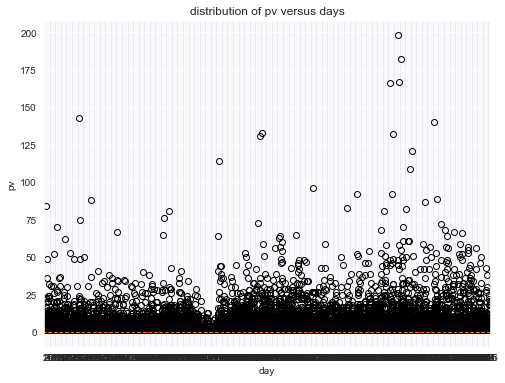

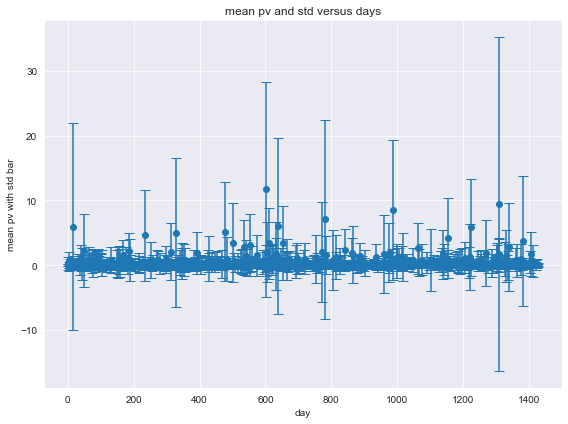

In [112]:
# 先看下时间序列上样本内达成pv的分布
import numpy as np
import matplotlib.pyplot as plt

# 示例数据，行为强度的时间序列数据（每列代表一个用户）
data = X_raw

# 计算各个用户行为强度的统计指标
mean_values = np.mean(data, axis=1)
std_values = np.std(data, axis=1)
quantiles = np.percentile(data, q=[25, 50, 75], axis=1)

# 绘制箱线图
plt.figure(figsize=(8, 6))
plt.boxplot(data, vert=True)
plt.xlabel('day')
plt.ylabel('pv')
plt.title('distribution of pv versus days')

# 绘制标准差区间图
plt.figure(figsize=(8, 6))
plt.errorbar( np.arange(data.shape[0]), mean_values, yerr=std_values, fmt='o', capsize=5)
plt.xlabel('day')
plt.ylabel('mean pv with std bar')
plt.title('mean pv and std versus days')

plt.tight_layout()
plt.show()

In [113]:
# 矩阵太稀疏，降维试试
from sklearn.decomposition import PCA
# 创建PCA对象并指定降维后的维度
pca = PCA(n_components=20)

# 进行PCA降维
X = pca.fit_transform(X_raw)
X.shape

(1428, 20)

/Users/admin/opt/anaconda3/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/Users/admin/opt/anaconda3/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


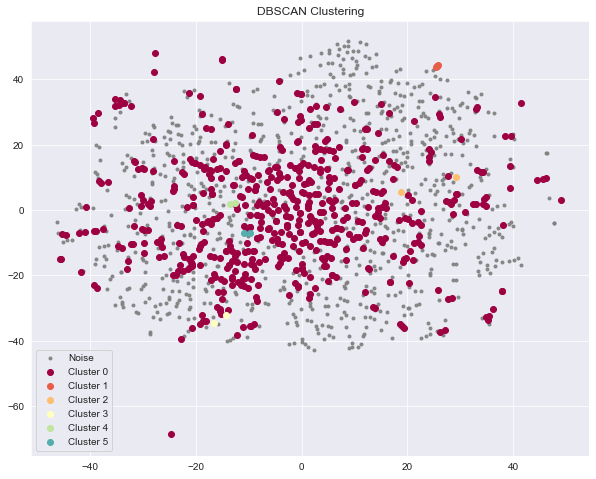

Cluster Sizes:
Noise Points: 854
Cluster 0: 564 points
Cluster 1: 2 points
Cluster 2: 2 points
Cluster 3: 2 points
Cluster 4: 2 points
Cluster 5: 2 points

DBSCAN Parameters:
Epsilon: 0.8
Min Samples: 2


In [114]:
# 试试DBSCAN聚类
import matplotlib.pyplot as plt
from sklearn.cluster import DBSCAN

# 执行 DBSCAN 聚类
dbscan = DBSCAN(eps=0.8, min_samples=2)
labels_dbscan = dbscan.fit_predict(X)

# 统计每个标签的样本数量
unique_labels, label_counts = np.unique(labels_dbscan, return_counts=True)

# 提取核心样本和噪声点
core_samples_mask = np.zeros_like(labels_dbscan, dtype=bool)
core_samples_mask[dbscan.core_sample_indices_] = True
noise_mask = labels_dbscan == -1

# 绘制散点图
unique_labels = set(labels_dbscan)
colors = plt.cm.Spectral(np.linspace(0, 1, len(unique_labels)))

# 创建 T-SNE 模型并拟合数据
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2, random_state=42)
X_plot = tsne.fit_transform(X_raw)

plt.figure(figsize=(10, 8))
# 先绘制噪音点，会使其位于图像下层
for label, color in zip(unique_labels, colors):
    if label == -1:
        # 绘制噪声点
        plt.scatter(X_plot[noise_mask, 0], X_plot[noise_mask, 1], color='grey', marker='.', alpha=0.9, label='Noise')
# 再绘制非噪声点，以免被噪声点覆盖
for label, color in zip(unique_labels, colors):
    if  label != -1:
        # 绘制聚类簇
        class_mask = labels_dbscan == label
        xy = X_plot[class_mask & core_samples_mask]
        plt.scatter(xy[:, 0], xy[:, 1], color=color, marker='o', label=f'Cluster {label}')

plt.title('DBSCAN Clustering')
plt.legend()
plt.show()

# 统计各簇的样本量
unique_labels, counts = np.unique(labels_dbscan, return_counts=True)
cluster_sizes = dict(zip(unique_labels, counts))

# 打印各簇的样本量
print("Cluster Sizes:")
for label, size in cluster_sizes.items():
    if label == -1:
        print(f"Noise Points: {size}")
    else:
        print(f"Cluster {label}: {size} points")

# 打印聚类参数
print("\nDBSCAN Parameters:")
print(f"Epsilon: {dbscan.eps}")
print(f"Min Samples: {dbscan.min_samples}")

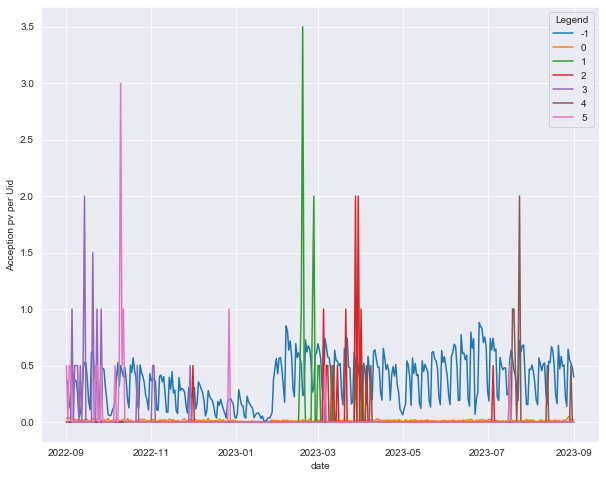

In [118]:
# 用均值来做可视化
df_new['Cluster'] = labels_dbscan
df_mean = df_new.groupby(['Cluster']).mean()



df_mean = df_mean.T
df_mean.index = pd.to_datetime(df_mean.index)
df_mean = df_mean.sort_index()
# df_mean = df_mean.reset_index()
df_mean.columns = df_mean.columns.astype(str)

plt.figure(figsize=(10, 8))
for label in df_mean.columns:
    plt.plot(df_mean.index,df_mean[label],label=label)
plt.xlabel('date')
plt.ylabel('Acception pv per Uid')
plt.legend(title='Legend', loc='upper right')
plt.show()


In [ ]:

# 使用K均值聚类算法，将用户行为划分为3个模式
k = 4
# 创建K-means聚类模型
kmeans = KMeans(n_clusters=k,init='k-means++', max_iter=3000, random_state=10)
kmeans.fit_predict(X)

# 获取聚类结果
labels_kmeans = kmeans.labels_
centroids_kmeans = kmeans.cluster_centers_

#把结果合并为一个df
df_clustered = df_new
df_clustered['Cluster'] = labels_kmeans

# 打印 DataFrame 的第一行
first_row_2 = df_clustered.head(n=1)
print(first_row_2)

# 统计每个标签的样本数量
unique_labels, label_counts = np.unique(labels_kmeans, return_counts=True)

# 输出聚类结果的概览
print("聚类数量：", len(unique_labels))
print("每个标签样本数量：", dict(zip(unique_labels, label_counts)))
print("聚类中心：", centroids_kmeans)



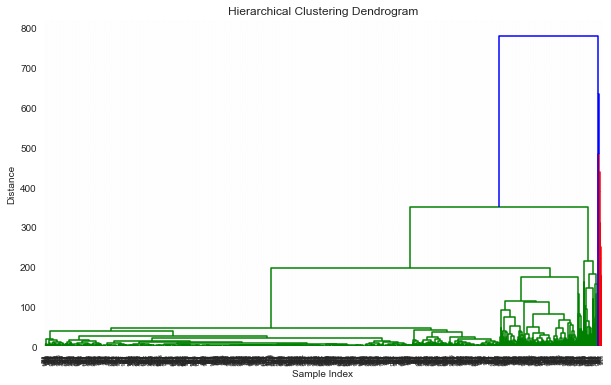

聚类数量： 4
每个标签样本数量： {0: 1413, 1: 2, 2: 1, 3: 12}
聚类中心： [[-1.41900970e+00 -3.97371480e-01 -1.36805027e-01 -4.38626841e-02
  -6.82676596e-02 -4.96009709e-02 -4.45962190e-02  1.76114858e-02
  -4.37198277e-02 -1.62002728e-02  2.92481819e-02  5.34910214e-03
   5.49185897e-02 -2.91206990e-02  7.50880071e-03  2.37279936e-02
  -2.55701973e-02  1.04640538e-02  8.60568911e-04  2.66099105e-03]
 [ 1.98868076e+02 -9.27177880e+01  1.40595275e+02 -7.13509920e+01
   1.72576569e+00 -7.96780974e+00  1.01768349e+01  3.86308917e+00
  -6.07376486e+00 -1.47476891e+01 -2.67644786e+01 -8.44664708e+00
  -2.50160335e+01  1.07960513e+01  1.08397677e+00  7.44728446e+00
  -2.01884419e+00 -7.72175556e+00 -3.62445853e+00 -2.25247047e+00]
 [ 4.35080399e+02 -2.20864540e+02 -1.65214310e+02  6.94060693e+01
  -4.16853868e+01  8.02226539e+00  1.67930556e+01 -1.12958904e+01
  -5.38292079e+00  1.55222474e+01  1.84436309e+00  9.72646738e+00
   5.48773810e+00 -1.17478636e+01 -2.92579707e+00 -6.92295893e+00
   2.58123445e+00  3.

In [56]:
# 再试试层次聚类
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
# 计算样本之间的距离矩阵
dist_matrix = linkage(X, method='ward')

# 根据阈值获取聚类标签
threshold = 2  # 设置阈值
labels_hier = fcluster(dist_matrix, threshold, criterion='distance')

# 绘制树状图（聚类结果）
plt.figure(figsize=(10, 6))
dendrogram(dist_matrix)
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('Sample Index')
plt.ylabel('Distance')
plt.show()

# 输出聚类结果的概览
print("聚类数量：", len(unique_labels))
print("每个标签样本数量：", dict(zip(unique_labels, label_counts)))
print("聚类中心：", centroids)
print("聚类中心的统计学参数：")
for label, centroid in zip(unique_labels, centroids):
    samples = X[labels == label]
    print("标签 {} 的样本数量：{}".format(label, len(samples)))
    # print("标签 {} 的均值：{}".format(label, np.mean(samples, axis=0)))
    # print("标签 {} 的标准差：{}".format(label, np.std(samples, axis=0)))
    print()


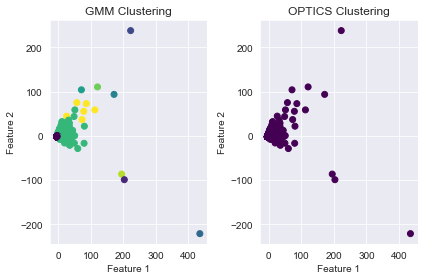

聚类数量： 4
每个标签样本数量： {0: 1413, 1: 2, 2: 1, 3: 12}
聚类中心： [[-1.41900970e+00 -3.97371480e-01 -1.36805027e-01 -4.38626841e-02
  -6.82676596e-02 -4.96009709e-02 -4.45962190e-02  1.76114858e-02
  -4.37198277e-02 -1.62002728e-02  2.92481819e-02  5.34910214e-03
   5.49185897e-02 -2.91206990e-02  7.50880071e-03  2.37279936e-02
  -2.55701973e-02  1.04640538e-02  8.60568911e-04  2.66099105e-03]
 [ 1.98868076e+02 -9.27177880e+01  1.40595275e+02 -7.13509920e+01
   1.72576569e+00 -7.96780974e+00  1.01768349e+01  3.86308917e+00
  -6.07376486e+00 -1.47476891e+01 -2.67644786e+01 -8.44664708e+00
  -2.50160335e+01  1.07960513e+01  1.08397677e+00  7.44728446e+00
  -2.01884419e+00 -7.72175556e+00 -3.62445853e+00 -2.25247047e+00]
 [ 4.35080399e+02 -2.20864540e+02 -1.65214310e+02  6.94060693e+01
  -4.16853868e+01  8.02226539e+00  1.67930556e+01 -1.12958904e+01
  -5.38292079e+00  1.55222474e+01  1.84436309e+00  9.72646738e+00
   5.48773810e+00 -1.17478636e+01 -2.92579707e+00 -6.92295893e+00
   2.58123445e+00  3.

In [53]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_moons
from sklearn.mixture import GaussianMixture
from sklearn.cluster import OPTICS


# 使用高斯混合模型进行聚类
gmm = GaussianMixture(n_components=10)
gmm.fit(X)
gmm_labels = gmm.predict(X)

# 使用 OPTICS 进行聚类
optics = OPTICS(min_samples=1)
optics.fit(X)
optics_labels = optics.labels_

# 绘制高斯混合模型聚类结果
plt.subplot(1, 2, 1)
plt.scatter(X[:, 0], X[:, 1], c=gmm_labels, cmap='viridis')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.title('GMM Clustering')

# 绘制 OPTICS 聚类结果
plt.subplot(1, 2, 2)
plt.scatter(X[:, 0], X[:, 1], c=optics_labels, cmap='viridis')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.title('OPTICS Clustering')

plt.tight_layout()
plt.show()

# 输出聚类结果的概览
print("聚类数量：", len(unique_labels))
print("每个标签样本数量：", dict(zip(unique_labels, label_counts)))
print("聚类中心：", centroids)
print("聚类中心的统计学参数：")
for label, centroid in zip(unique_labels, centroids):
    samples = X[labels == label]
    print("标签 {} 的样本数量：{}".format(label, len(samples)))
    # print("标签 {} 的均值：{}".format(label, np.mean(samples, axis=0)))
    # print("标签 {} 的标准差：{}".format(label, np.std(samples, axis=0)))
    print()


No handles with labels found to put in legend.


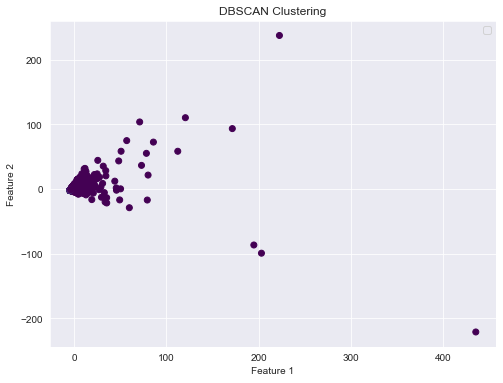

In [71]:
# 利用PCA降维查看聚类效果

from sklearn.decomposition import PCA
# 创建PCA对象并指定降维后的维度
pca = PCA(n_components=2)

# 进行PCA降维
X_new = pca.fit_transform(X)

# 绘制聚类结果
plt.figure(figsize=(8, 6))

# 绘制每个样本点
plt.scatter(X_new[:, 0], X_new[:, 1], c=labels_dbscan, cmap='viridis')

# 绘制聚类中心
# plt.scatter(centroids[:, 0], centroids[:, 1], marker='x', color='red', s=100, label='Centroids')

# 设置图形属性
plt.title('DBSCAN Clustering')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.legend()

# 显示图形
plt.show()

In [6]:
# 用均值来做可视化
# df_sum = df_new.groupby(['Cluster']).sum()
df_sum = df_new.groupby(['Cluster']).mean()

import seaborn as sns
sns.lineplot()
plt.xlabel('Date')
plt.ylabel('Sum of pv')
plt.legend(title='Cluster')
plt.show()

TypeError: Cannot interpret '<attribute 'dtype' of 'numpy.generic' objects>' as a data type

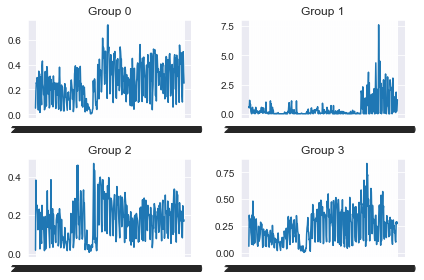

In [7]:
# 创建一个 2x2 的子图布局，将四张图表放在不同的子图中
fig, axes = plt.subplots(2, 2)

# 绘制第一张图
axes[0, 0].plot(df_sum.T[0])
axes[0, 0].set_title('Group 0')

# 绘制第二张图
axes[0, 1].plot(df_sum.T[1])
axes[0, 1].set_title('Group 1')

# 绘制第三张图
axes[1, 0].plot(df_sum.T[2])
axes[1, 0].set_title('Group 2')

# 绘制第四张图
axes[1, 1].plot(df_sum.T[3])
axes[1, 1].set_title('Group 3')

# 调整子图之间的间距
plt.tight_layout()

# 展示图表
plt.show()

In [ ]:
fig, axes = plt.subplots(4, 1,figsize=(20, 10))


# 对每组用户的时间序列进行季节性分解
for i in range(len(df_sum.T.columns)):
    user_data = df_sum.T.iloc[:, i]
    # 将数据索引转换为带有频率的 DatetimeIndex
    user_data.index = pd.to_datetime(user_data.index)
    user_data = user_data.asfreq('D')  # 设置适当的频率，如 'D' 表示按日
    #print(user_data)
    decomposition = sm.tsa.seasonal_decompose(user_data, model="additive")
    
    #趋势
    trend = decomposition.trend
    #季节性
    seasonal = decomposition.seasonal
    #残差
    residual = decomposition.resid

    axes[i].plot(trend)
    axes[i].plot(seasonal)
    axes[i].plot(residual)
    axes[i].legend()
    axes[i].set_title('Group {}'.format(i))



# 调整子图之间的间距
plt.tight_layout()
   
# 展示图表
plt.show()